In [1]:
#importing necessary libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_MpHjUjU.csv') # Loading the dataset 
train[:10] #Checking first 10 rows of it

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
7,2017-02-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
8,2017-03-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,350000,1
9,2017-04-01,4,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1


We see that there are multiple rows for the same employee with different Total Business Values hence we will group the data on the basis of Emp_ID and add up the Total Business Value to get single record for Each employee.

In [12]:
train.drop_duplicates(inplace = True)  #Dropping duplicates
print(train.shape) #Checking the shape after removing duplicates

(19104, 14)


In [173]:
train.columns # to check the columns to use in grouping and making col with it.

Index(['MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

**DataCleaning and Feature Engineering**

In [3]:
#getting the employee id's of the those who have left the organisation

attrition = train[['Emp_ID','LastWorkingDate','Dateofjoining']].dropna()
attrition.sort_index(inplace=True)
attrition['Dateofjoining'] = pd.to_datetime(attrition['Dateofjoining'])
attrition['LastWorkingDate'] = pd.to_datetime(attrition['LastWorkingDate'], errors = 'ignore')
attrition['Tenurity'] = attrition['LastWorkingDate'] - attrition['Dateofjoining']
attrition['Tenurity'] = attrition['Tenurity'].apply(lambda x: str(x))
attrition.head(4)

,Emp_ID,LastWorkingDate,Dateofjoining,Tenurity
2,1,2016-03-11,2015-12-24,78 days 00:00:00
9,4,2017-04-27,2016-12-07,141 days 00:00:00
12,5,2016-03-07,2016-01-09,58 days 00:00:00
20,8,2017-11-15,2017-09-19,57 days 00:00:00


**Data for the employees who have left are separated**

**New Feature tenurity is derived from existing columns of LastWorkingDate and DateofJoining for them**

In [44]:
#Creating a new dataframe and grouping them together to get single row of data for each employee

df = train.groupby(['Emp_ID'], sort=False, as_index=False).agg(lambda x: np.unique(x).sum()) 
df.sort_index(inplace=True)

df.shape #Checking the shape of dataframe

(2381, 12)

In [129]:
#Merging both the extracted dataset together

df2 = pd.merge(df, attrition, on='Emp_ID', how='left')
df2.shape

(2381, 15)

In [130]:
#Creating a new column named attrition depending upon whether they have left..

df2['Attrition'] = pd.Series((df.Emp_ID.isin(attrition.Emp_ID)))
df2.shape


(2381, 16)

In [131]:
#Replacing the values of Attrition column True as 1(Left the origanisation), False as 0(didn't left yet)

df2['Attrition'].replace({True:[1],False:[0]}, regex = True, inplace = True)
df2.head(2)

,Emp_ID,MMM-YY,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,LastWorkingDate,Dateofjoining_y,Tenurity,Attrition
0,1,2016-01-012016-02-012016-03-01,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,2016-03-11,2015-12-24,78 days 00:00:00,1
1,2,2017-11-012017-12-01,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,NaT,NaT,NaN,0


In [132]:
# Dropping MMM-YY, Dateofjoining_y, LastWorkingDate column from the dataset.

df2.drop(['MMM-YY','Dateofjoining_y','LastWorkingDate'], axis =1, inplace = True)
df2.head(2)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,78 days 00:00:00,1
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,NaN,0


In [133]:
#Converting datatype of Dateofjoining_x to derive tenurity of remaining emloyees taking present day as 2017-12-31.

df2['Dateofjoining_x'] = pd.to_datetime(df2['Dateofjoining_x'])

#Filling up nan values of Tenurity

from datetime import datetime
a_date = datetime.strptime('2017/12/31', "%Y/%m/%d") #Choosing the last working day of the quarter 
df2['Tenurity'].fillna(a_date - df2['Dateofjoining_x'], inplace = True)
df2.head(10)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,78 days 00:00:00,1
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,55 days 00:00:00,0
2,4,43,Male,C13,Master,65603,2016-12-07,2,2,350000,1,141 days 00:00:00,1
3,5,29,Male,C9,College,46368,2016-01-09,1,1,120360,1,58 days 00:00:00,1
4,6,31,Female,C11,Bachelor,78728,2017-07-31,3,3,1265000,3,153 days 00:00:00,0
5,8,34,Male,C2,College,70656,2017-09-19,3,3,0,1,57 days 00:00:00,1
6,11,28,Female,C19,Master,42172,2017-12-07,1,1,0,1,24 days 00:00:00,0
7,12,35,Male,C23,Master,28116,2016-06-29,1,1,2607180,5,175 days 00:00:00,1
8,13,90,Male,C19,Master,119227,2012-05-28,1,4,9563040,3,2007 days 00:00:00,1
9,14,39,Female,C26,College,19734,2017-10-16,3,3,0,1,76 days 00:00:00,0


In [134]:
# Creating new feature Promotion based on existing feature of Designation and joining Designation

df2['Promoted'] =  df2['Designation'] - df2['Joining Designation']
df2.head(4)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining_x,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,1715580,2,78 days 00:00:00,1,0
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,0,1,55 days 00:00:00,0,0
2,4,43,Male,C13,Master,65603,2016-12-07,2,2,350000,1,141 days 00:00:00,1,0
3,5,29,Male,C9,College,46368,2016-01-09,1,1,120360,1,58 days 00:00:00,1,0


**We Created new column based on existing column of Joining Designation and Current Designation**

In [135]:
#Separating day, month and year and making new features for that.
df2['Joining Day'] = df2['Dateofjoining_x'].dt.day
df2['Joining Month'] = df2['Dateofjoining_x'].dt.month
df2['Joining Year'] = df2['Dateofjoining_x'].dt.year

#Removing the existing DateofJoining column from the dataset as new features already created from it.
df2.drop(['Dateofjoining_x'], axis = 1, inplace = True)
df2.head()

,Emp_ID,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year
0,1,28,Male,C23,Master,57387,1,1,1715580,2,78 days 00:00:00,1,0,24,12,2015
1,2,31,Male,C7,Master,67016,2,2,0,1,55 days 00:00:00,0,0,6,11,2017
2,4,43,Male,C13,Master,65603,2,2,350000,1,141 days 00:00:00,1,0,7,12,2016
3,5,29,Male,C9,College,46368,1,1,120360,1,58 days 00:00:00,1,0,9,1,2016
4,6,31,Female,C11,Bachelor,78728,3,3,1265000,3,153 days 00:00:00,0,0,31,7,2017


In [136]:
# Changed the datatype of Tenurity and removed unwanted string values from each of the value.

df2['Tenurity'] =  df2['Tenurity'].apply(lambda x: str(x).split(' ')[0])

df2['Tenurity'] = df2['Tenurity'].astype(int) #for changing the datatype.

**Data Visualisation**

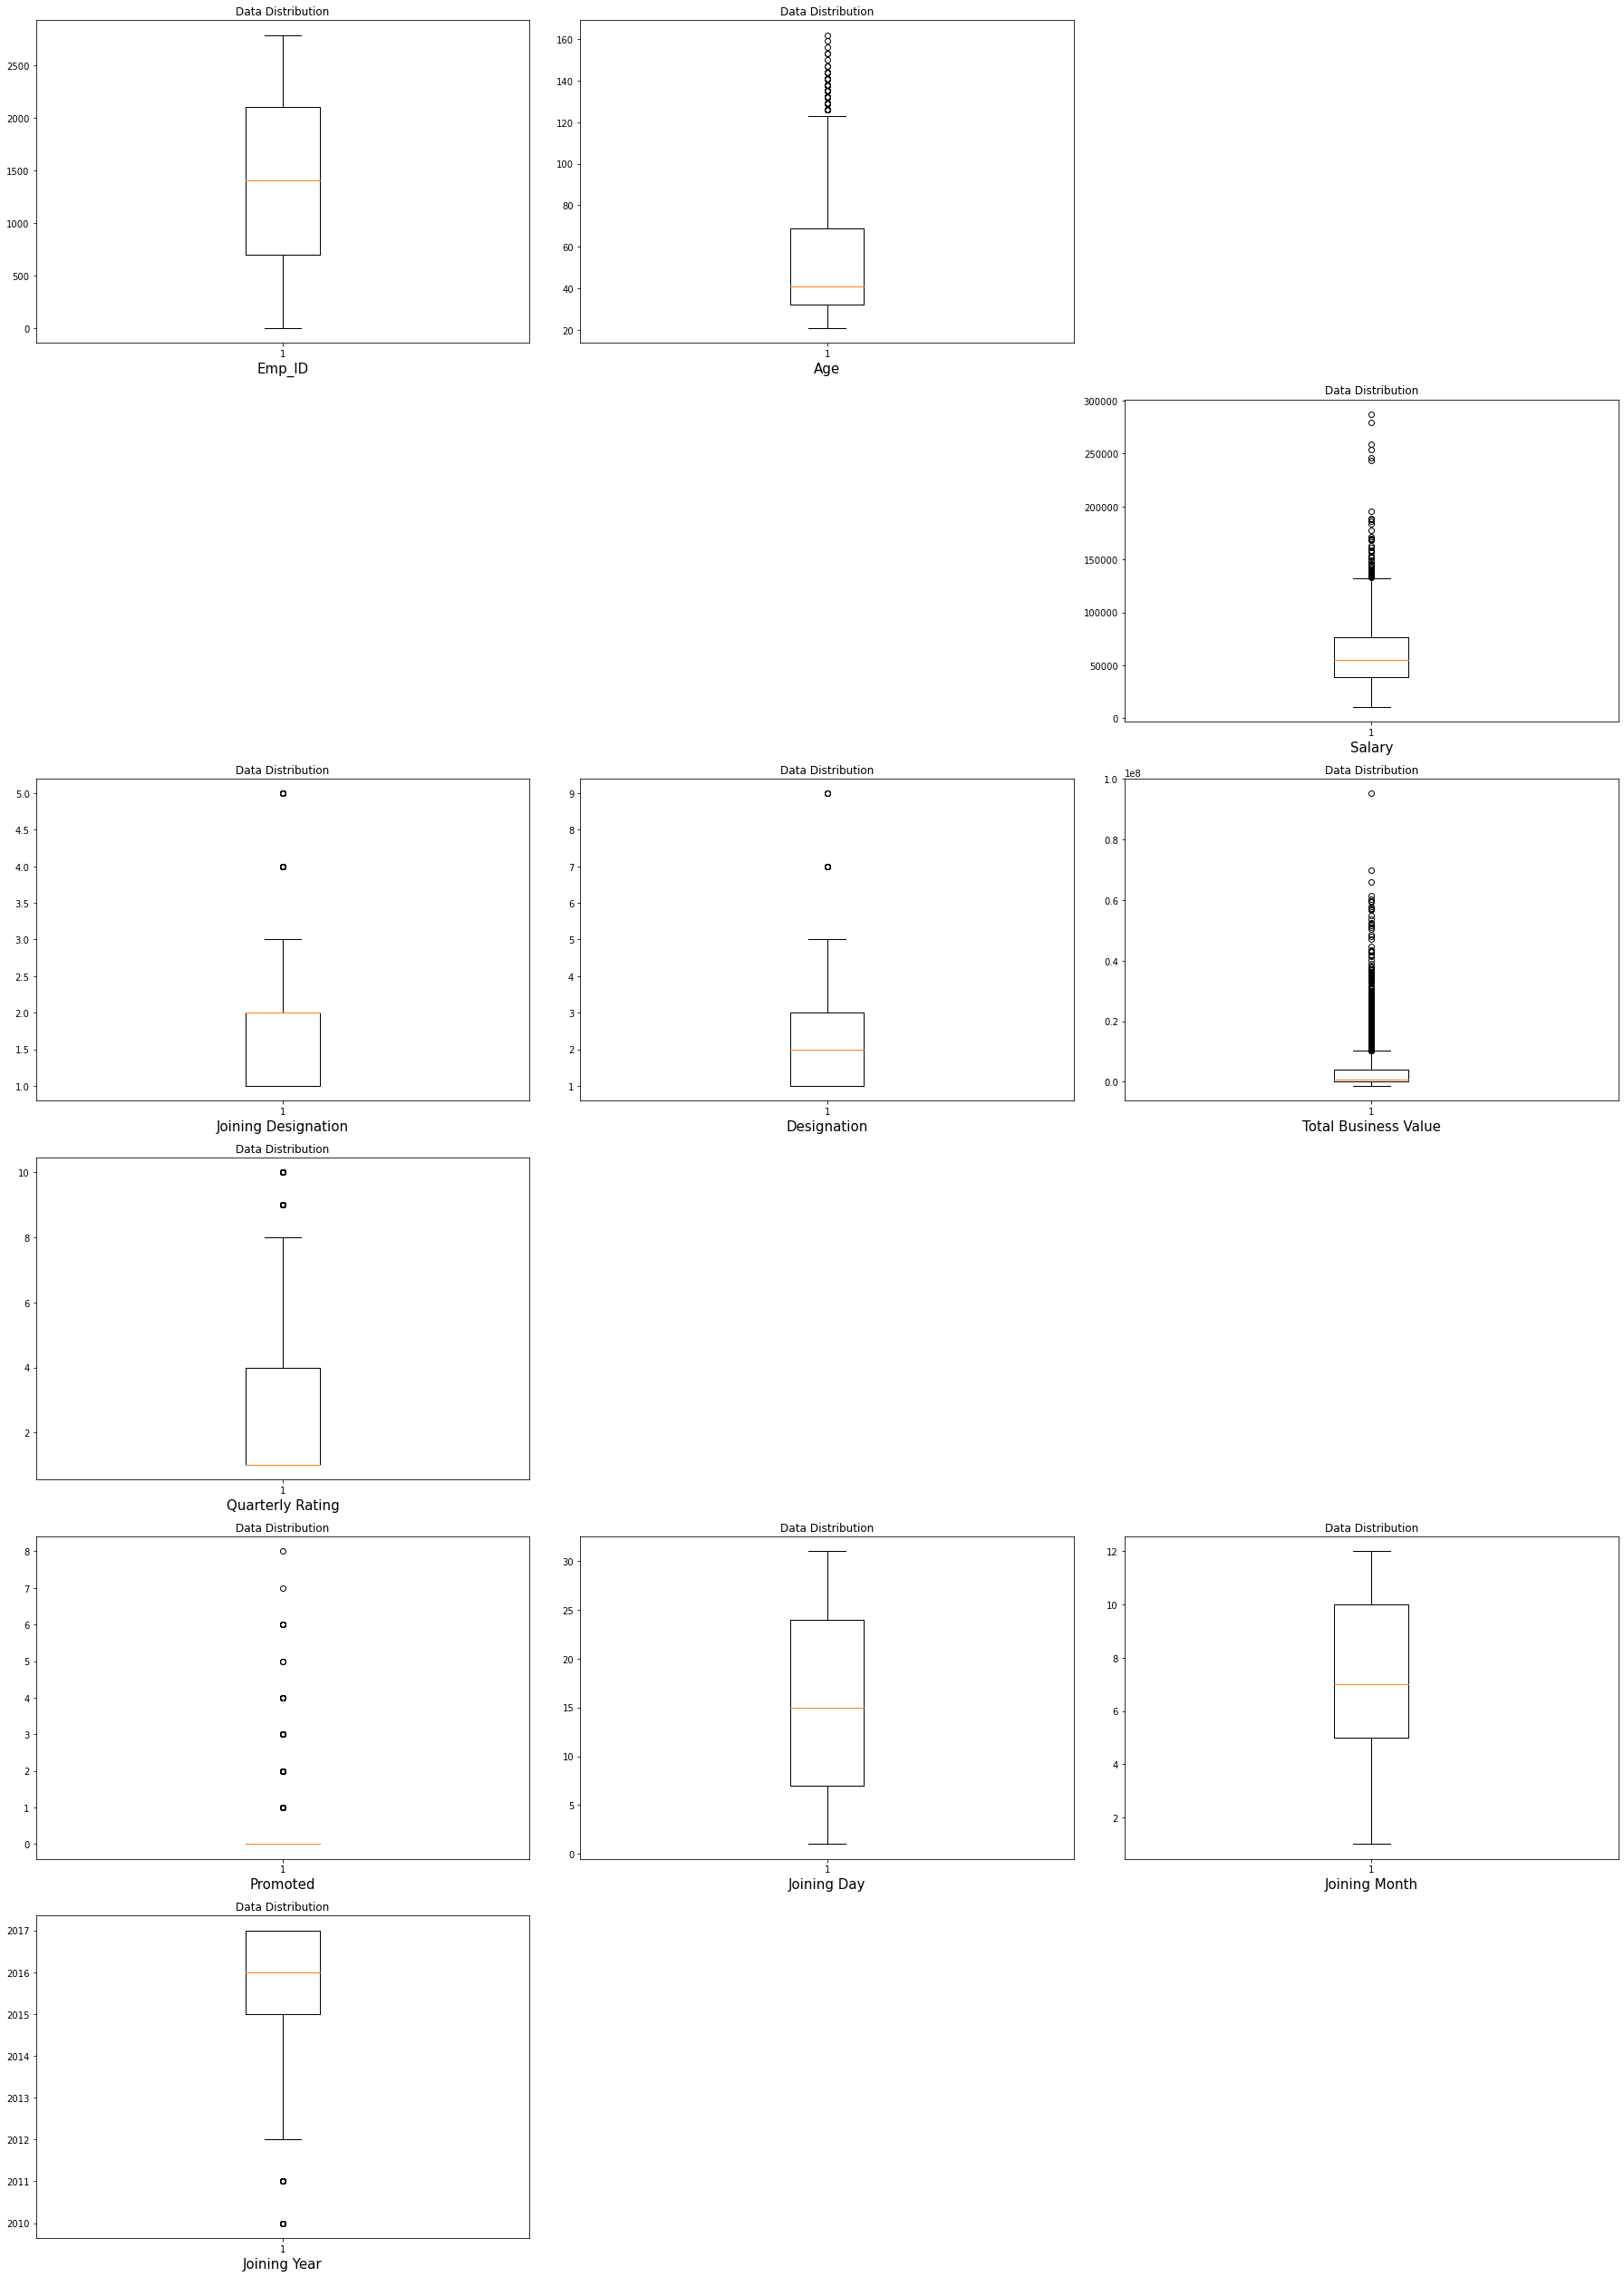

In [24]:
#Checking for outliers in the dataset.

plt.figure(figsize = [25,35])
plotnumber = 1

for column in df2:
    if df2[column].dtypes=="int64" or df2[column].dtypes=="float64" and plotnumber<=16:
        ax = plt.subplot(6,3,plotnumber)
        plt.boxplot(x = df2[column])
        plt.xlabel(column, fontsize = 15)
        plt.title("Data Distribution", fontsize = 12)
    plotnumber += 1
plt.tight_layout()

**Outliers are found in the features Salary, Total Business Value and Age**

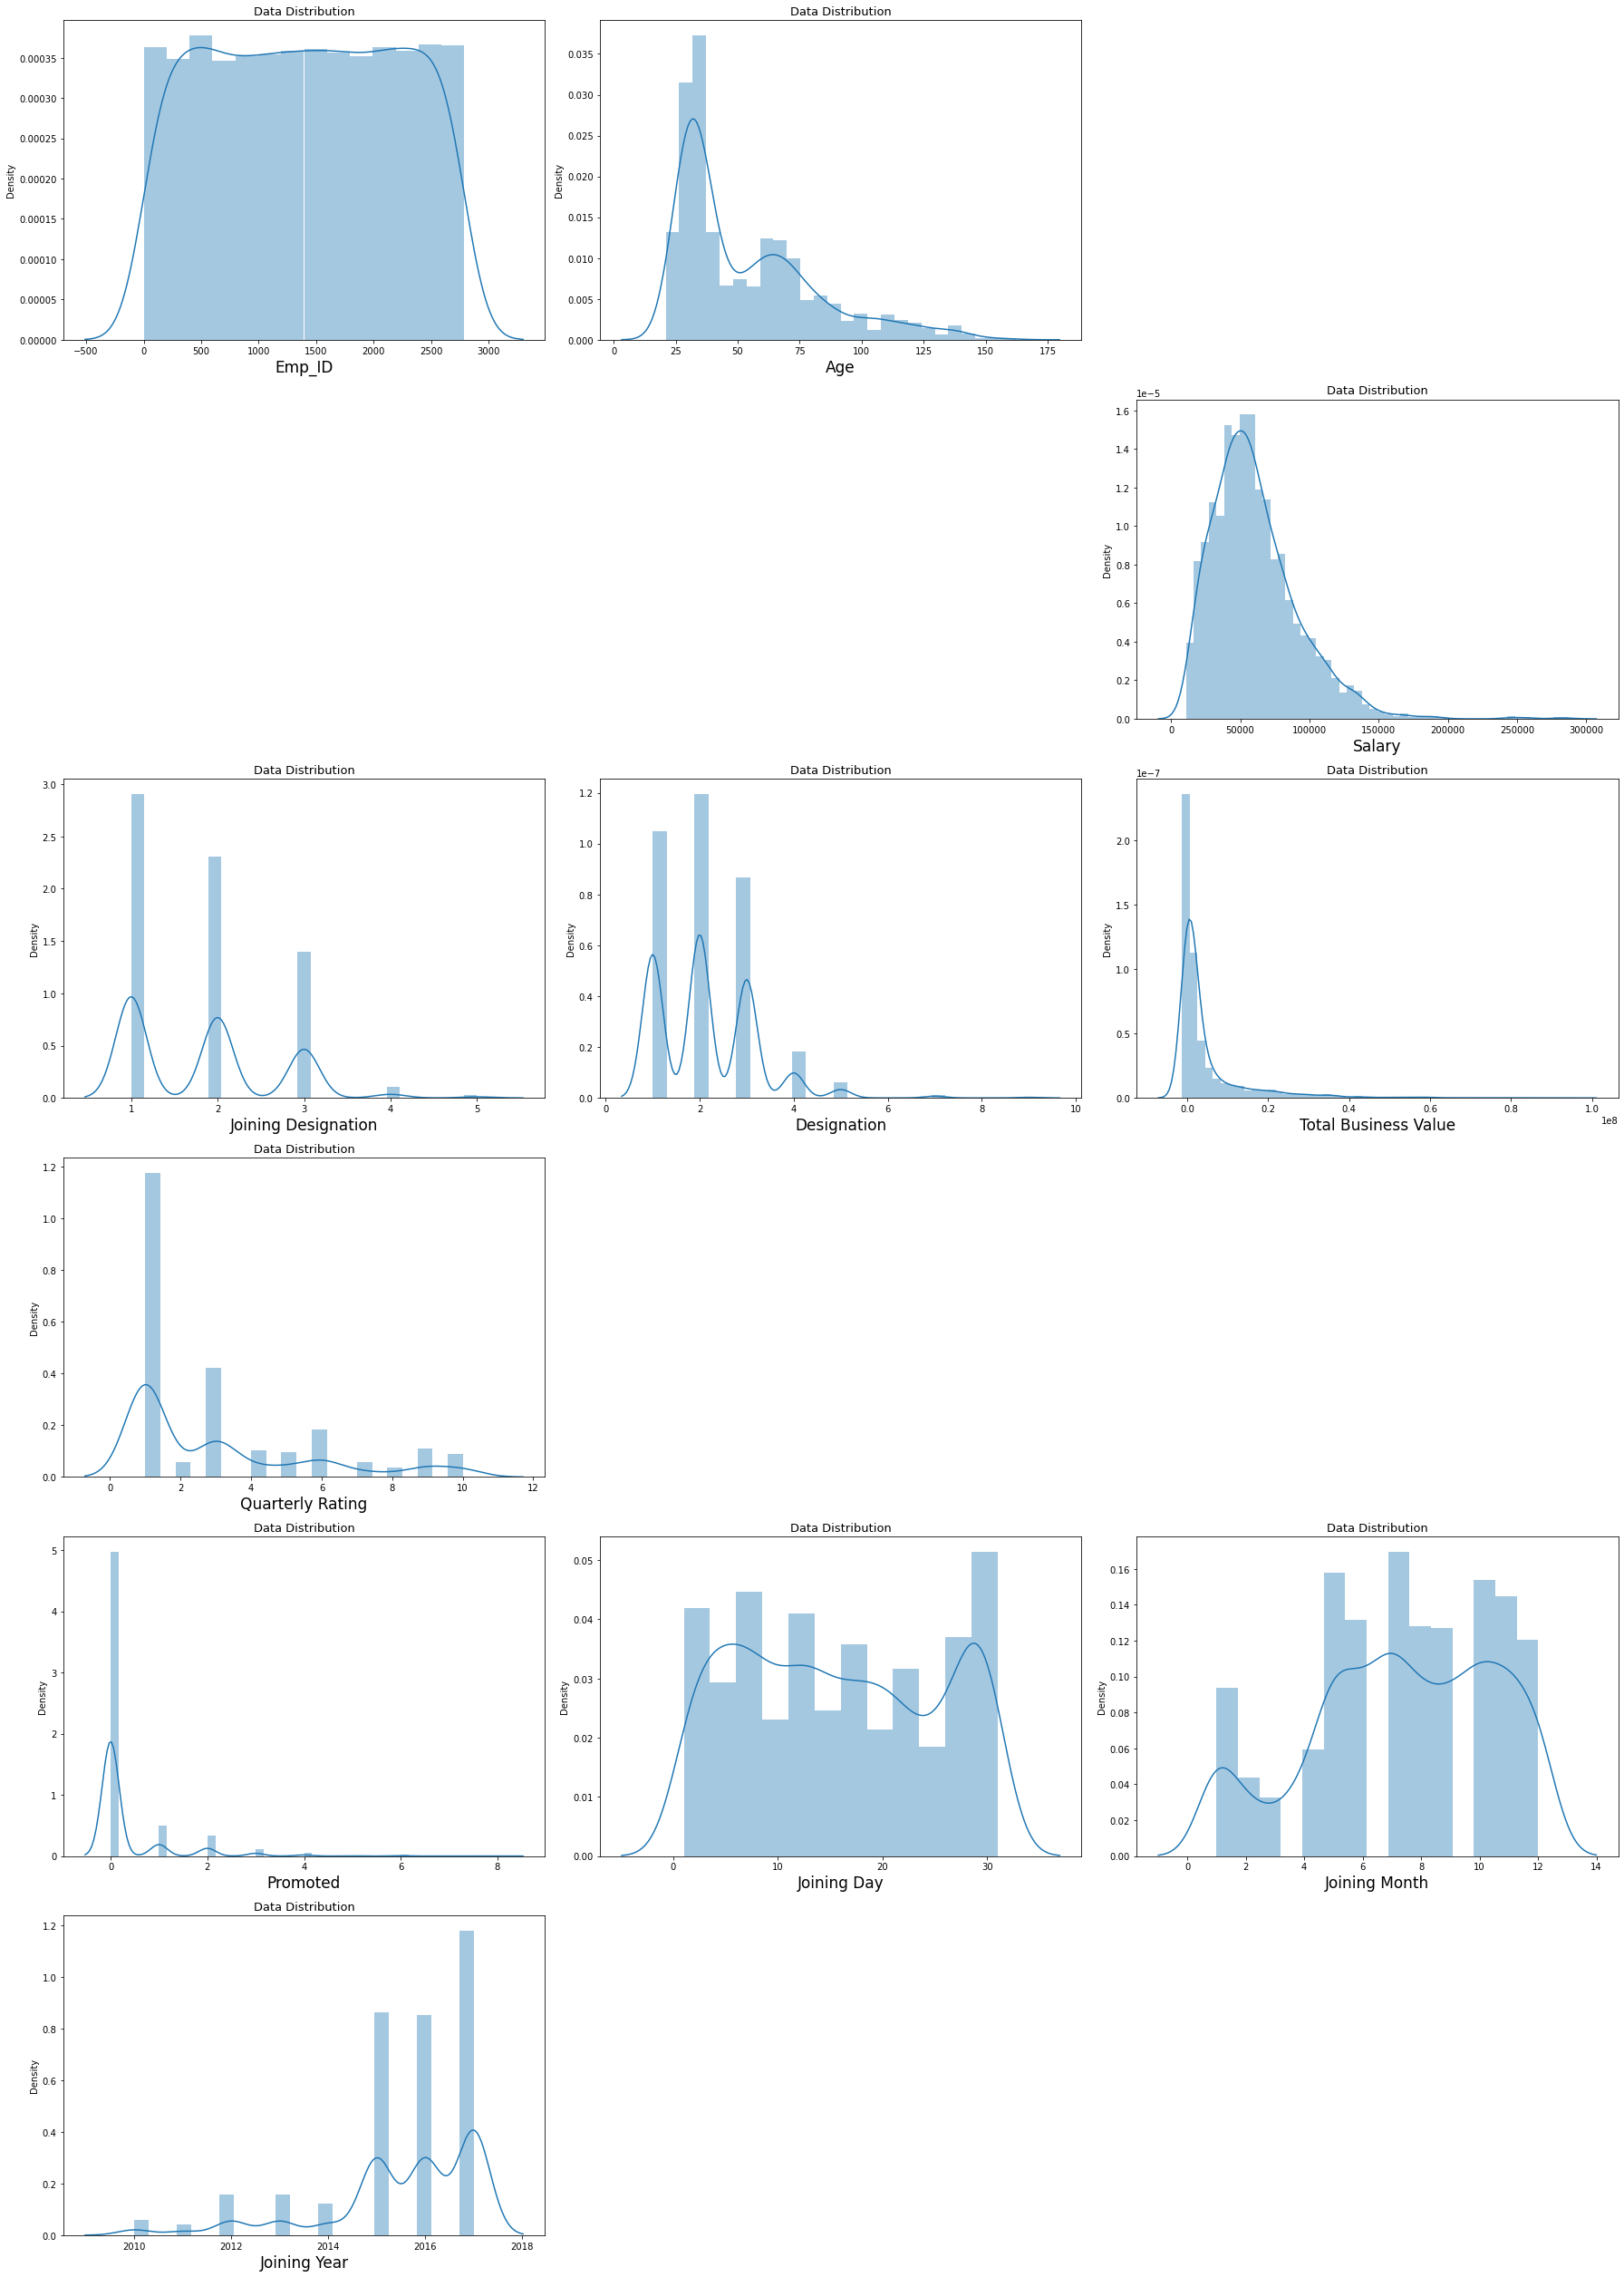

In [23]:
#Let's now check for skewness in the dataset

plt.figure(figsize=[25,35])
plotnumber = 1

for column in df2:
    if df2[column].dtypes=="int64" or df2[column].dtypes=="float64" and plotnumber<=16:
        ax = plt.subplot(6,3,plotnumber)
        sns.distplot(df2[column])
        plt.xlabel(column,fontsize=17)
        plt.title("Data Distribution", fontsize = 13)
    plotnumber+=1
plt.tight_layout()

In [22]:
df2.skew() #checking skewness in the dataset.

Emp_ID                 -0.003884
Age                     1.214731
Salary                  1.421245
Joining Designation     0.687900
Designation             1.173639
Total Business Value    3.374370
Quarterly Rating        1.223823
Tenurity                2.053035
Attrition              -0.765864
Promoted                3.500004
Joining Day             0.097936
Joining Month          -0.371510
Joining Year           -1.414548
dtype: float64

**Skewness is found in the features Salary, Total Business Value and Age**

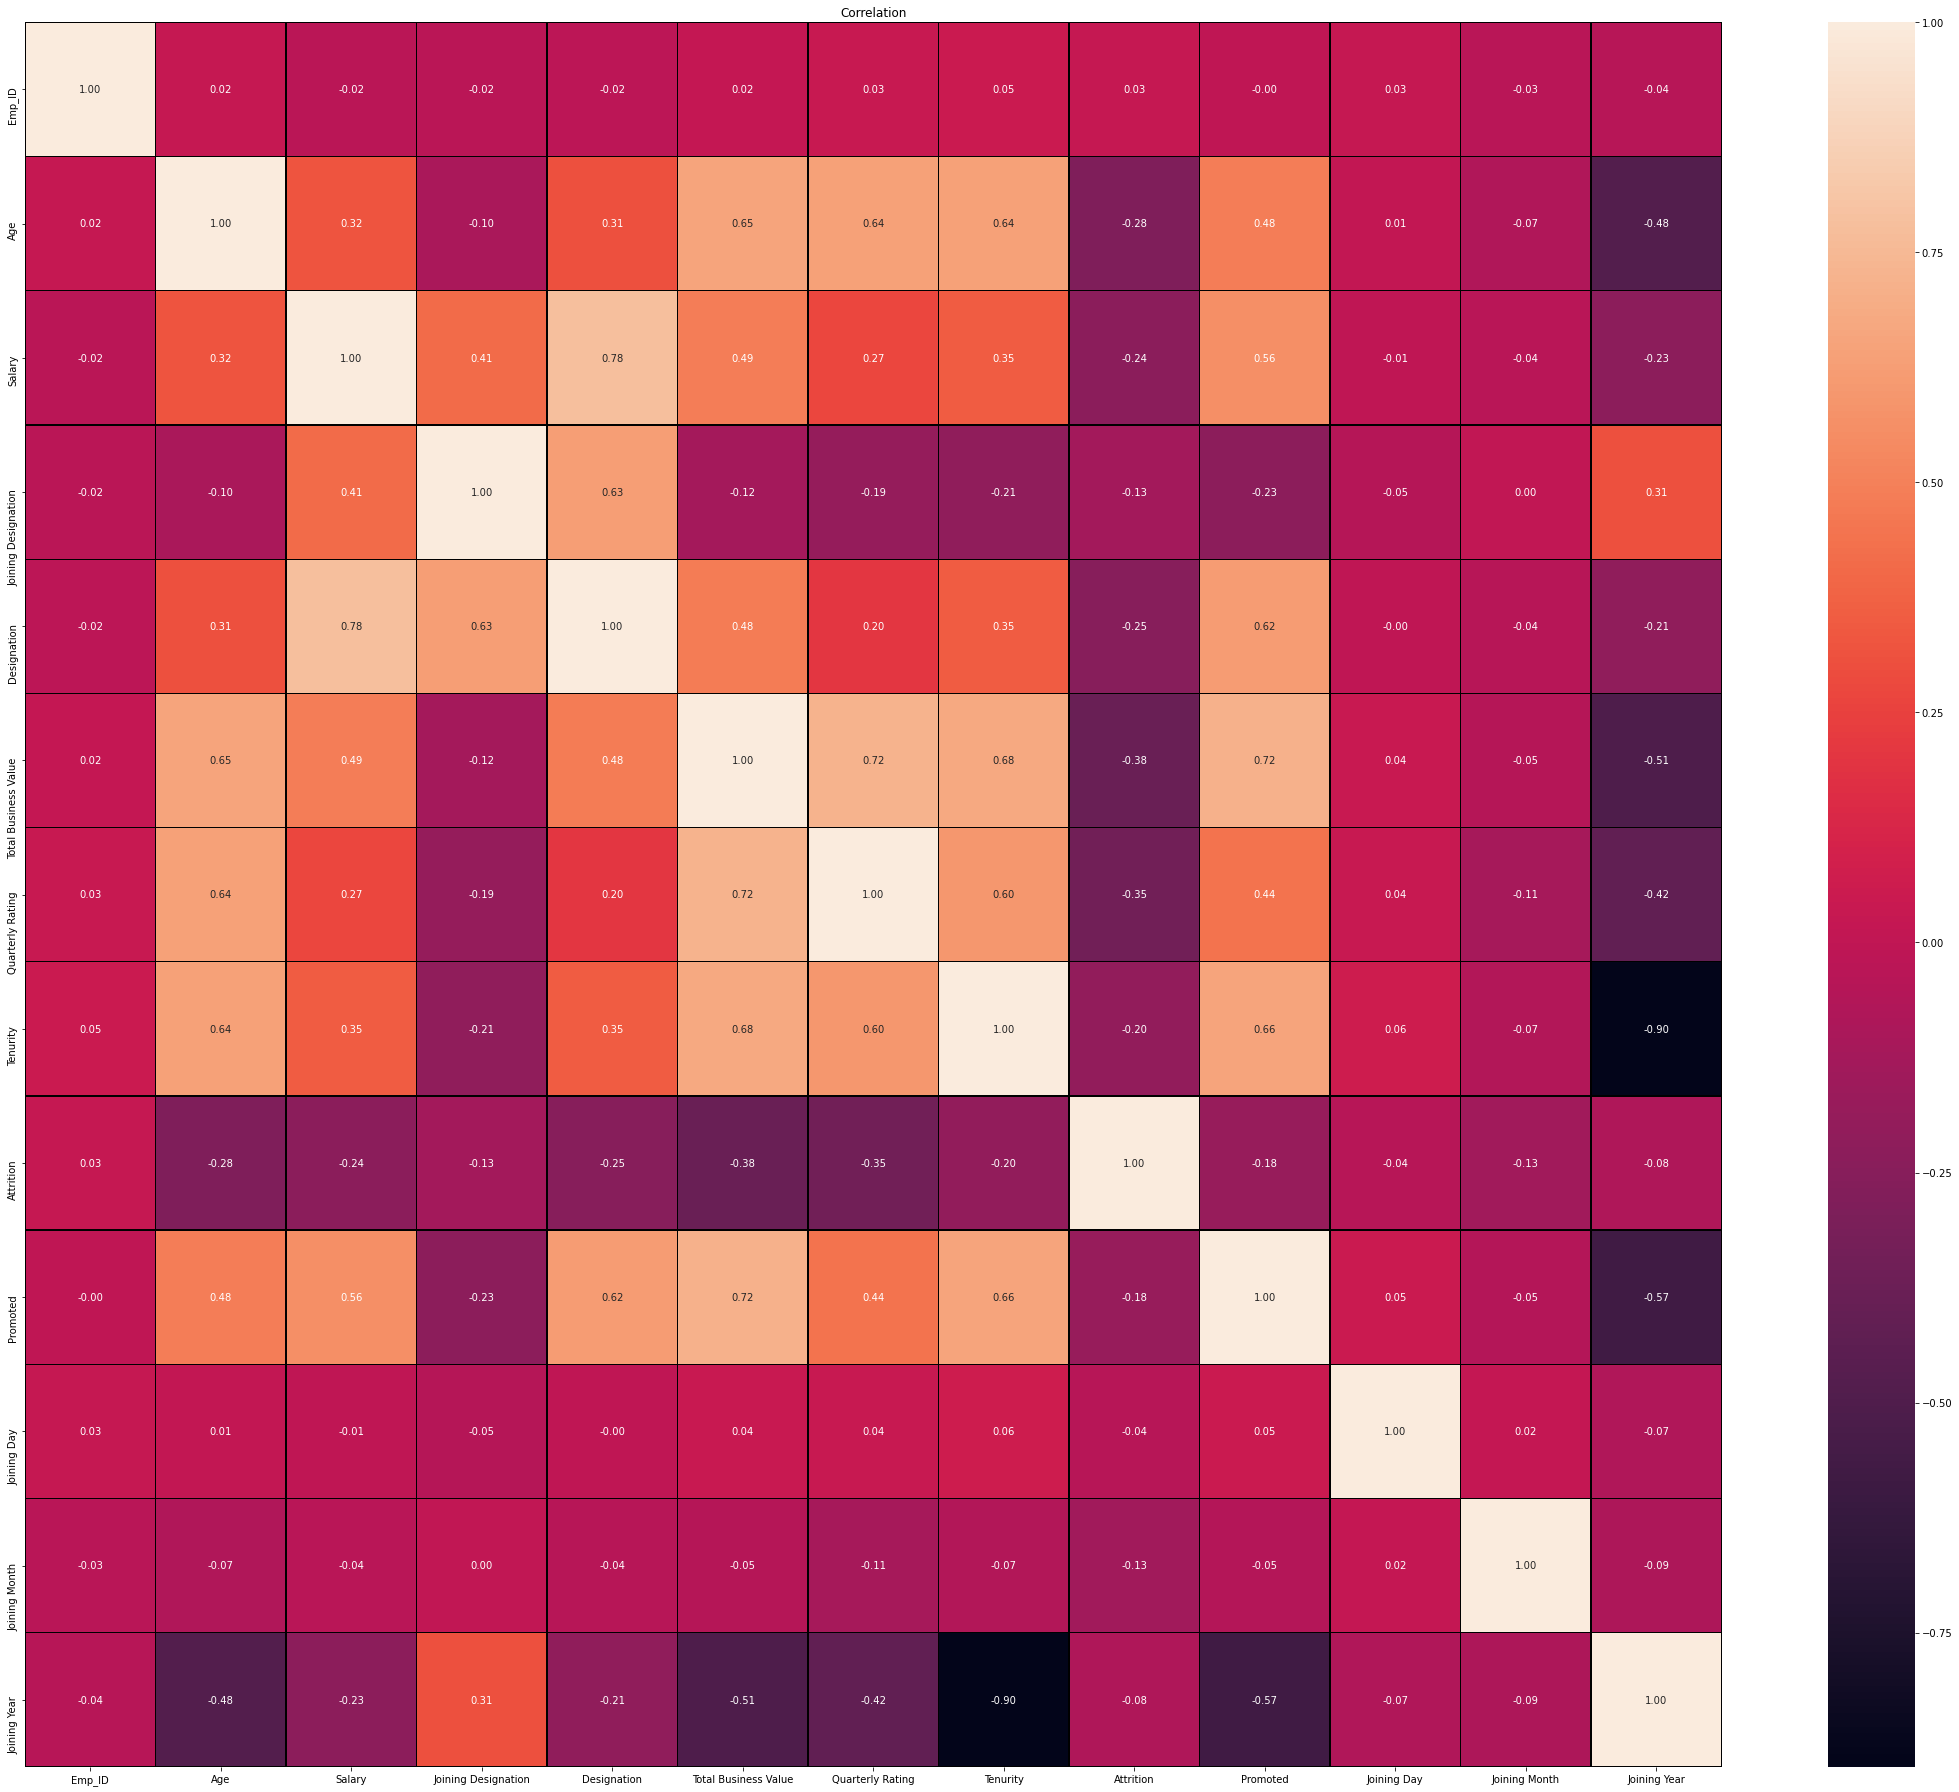

In [53]:
#Let's check for co-relation among features

plt.figure(figsize = [30,25])
sns.heatmap(df2.corr(),annot=True, linewidths=0.3,linecolor="black",fmt='.2f' )
plt.title('Correlation')
plt.tight_layout()

**There isn't any co-linearity found among the features**

**Data-Preprocessing**

In [137]:
#Dropped off the columns Emp_ID and Attrition as after checking everyting are not found to be important.

df3 = df2.drop(['Emp_ID'], axis = 1)

In [138]:
#Removing Skewness

q = df3['Age'].quantile(0.98)
df3 = df3[df3['Age']<q]

q = df3['Salary'].quantile(0.98)
df3 = df3[df3['Salary']<q]

q = df3['Total Business Value'].quantile(0.97)
df3 = df3[df3['Total Business Value']<q]

q = df3['Tenurity'].quantile(0.97)
df3 = df3[df3['Tenurity']<q]

df3.skew()

Age                     1.140995
Salary                  0.623109
Joining Designation     0.537589
Designation             0.430866
Total Business Value    2.650402
Quarterly Rating        1.520051
Tenurity                2.258140
Attrition              -0.989519
Promoted                3.916185
Joining Day             0.120906
Joining Month          -0.359110
Joining Year           -1.123824
dtype: float64

In [139]:
#Removing outliers with the help of Z-score Method.

from scipy import stats

z = np.abs(stats.zscore(df3['Total Business Value']))
i = np.where(z>3)[0]

print(i)

[  26   39   55   72  115  297  308  340  444  445  509  537  550  576
  593  640  681  685  693  727  757  760  849  852  861  893  926  965
 1051 1054 1088 1102 1128 1287 1318 1367 1389 1392 1411 1424 1425 1438
 1486 1509 1559 1576 1598 1619 1624 1680 1714 1740 1748 1760 1772 1835
 1855 1895 1896 1922 1926 1938 1963 1996 2032 2077 2103]


In [75]:
# Removing the indexes from the entire datatset.

df3 = df3.drop(df3.index[i])

df3.head(2)

,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Promoted,Joining Day,Joining Month,Joining Year
0,28,Male,C23,Master,57387,1,1,1715580,2,78,0,24,12,2015
1,31,Male,C7,Master,67016,2,2,0,1,55,0,6,11,2017


In [76]:
#Doing label encoding for Education_level column

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df3['Education_Level'] = le.fit_transform(df3['Education_Level'])
df3.head(4)

,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Promoted,Joining Day,Joining Month,Joining Year
0,28,Male,C23,2,57387,1,1,1715580,2,78,0,24,12,2015
1,31,Male,C7,2,67016,2,2,0,1,55,0,6,11,2017
2,43,Male,C13,2,65603,2,2,350000,1,141,0,7,12,2016
3,29,Male,C9,1,46368,1,1,120360,1,58,0,9,1,2016


In [77]:
#Performed get dummies on the remaining categorical data.

final_train = pd.get_dummies(data = df3, columns = ['Gender','City'])
final_train

,Age,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Promoted,Joining Day,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28,2,57387,1,1,1715580,2,78,0,24,...,0,0,0,0,0,0,0,0,0,0
1,31,2,67016,2,2,0,1,55,0,6,...,0,0,0,0,0,0,0,1,0,0
2,43,2,65603,2,2,350000,1,141,0,7,...,0,0,0,0,0,0,0,0,0,0
3,29,1,46368,1,1,120360,1,58,0,9,...,0,0,0,0,0,0,0,0,0,1
4,31,0,78728,3,3,1265000,3,153,0,31,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,26,0,29582,1,1,0,1,92,0,16,...,0,0,0,0,0,0,0,0,0,0
2377,34,1,12105,1,1,0,1,61,0,28,...,0,0,0,0,0,0,0,0,0,1
2378,89,1,35370,2,2,2815090,3,419,0,31,...,0,0,0,0,0,0,0,0,0,0
2379,28,2,69498,1,1,977830,3,335,0,21,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#Importing and applying normalize to bring the data to same scale

from sklearn.preprocessing import normalize

scaled = normalize(final_train)

In [142]:
final_train.columns

Index(['Age', 'Education_Level', 'Salary', 'Joining Designation',
       'Designation', 'Total Business Value', 'Quarterly Rating', 'Tenurity',
       'Promoted', 'Joining Day', 'Joining Month', 'Joining Year',
       'Gender_Female', 'Gender_Male', 'City_C1', 'City_C10', 'City_C11',
       'City_C12', 'City_C13', 'City_C14', 'City_C15', 'City_C16', 'City_C17',
       'City_C18', 'City_C19', 'City_C2', 'City_C20', 'City_C21', 'City_C22',
       'City_C23', 'City_C24', 'City_C25', 'City_C26', 'City_C27', 'City_C28',
       'City_C29', 'City_C3', 'City_C4', 'City_C5', 'City_C6', 'City_C7',
       'City_C8', 'City_C9'],
      dtype='object')

**Model Building**

In [79]:
#Importing Kmeans Clustering and fitting the data into it using n_clusters as 2 as we need 2 clusters

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=200, n_init = 300, max_iter = 10000, precompute_distances = True, n_jobs = -1 ).fit(scaled)

In [38]:
# Checking for which cluster the data of employee who has left belongs to.

In [107]:
#normalized one data of an employee who has left the organization for making the predictions.

x = final_train.iloc[6:7,0:]

In [108]:
kmeans.predict(x)

array([0])

We get to know from this that the people who have left belongs to cluster 0 after predictions which we will have to change.

**Test Prediction**

In [109]:
#loading the test data

test = pd.read_csv('test_hXY9mYw.csv')
test.head(4)

,Emp_ID
0,394
1,173
2,1090
3,840


In [110]:
#Getting other features of the test data from our df2 which we had created from our train dataset.

test = df2[df2['Emp_ID'].isin(test['Emp_ID'])]
test.head(2)

,Emp_ID,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Attrition,Promoted,Joining Day,Joining Month,Joining Year
1,2,31,Male,C7,Master,67016,2,2,0,1,55,0,0,6,11,2017
4,6,31,Female,C11,Bachelor,78728,3,3,1265000,3,153,0,0,31,7,2017


In [140]:
#Dropping Emp_id and Attrition as it is not used in building the model

final_test = df2.drop(['Emp_ID','Attrition'], axis =1)

#Encoding the categorical features.

final_test['Education_Level'] = le.fit_transform(final_test['Education_Level'])
final_test = pd.get_dummies(data = final_test, columns = ['Gender','City'])
final_test.head(4)

,Age,Education_Level,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating,Tenurity,Promoted,Joining Day,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28,2,57387,1,1,1715580,2,78,0,24,...,0,0,0,0,0,0,0,0,0,0
1,31,2,67016,2,2,0,1,55,0,6,...,0,0,0,0,0,0,0,1,0,0
2,43,2,65603,2,2,350000,1,141,0,7,...,0,0,0,0,0,0,0,0,0,0
3,29,1,46368,1,1,120360,1,58,0,9,...,0,0,0,0,0,0,0,0,0,1


In [146]:
#Scaling the test data.

final_test = normalize(final_test)

In [147]:
#Predicting the target variable

In [148]:
df2['Target'] = kmeans.predict(final_test)

In [149]:
#Changing the predicted cluster values.

In [150]:
df2['Target'].replace({1:4,0:3}, inplace = True)
df2['Target'].replace({4:0,3:1}, inplace = True)

In [151]:
#Exporting the predictions and Emp_ID in csv format.

In [152]:
save = df2[['Emp_ID','Target']]
save.to_csv('last.csv')